# Úkol č. 1 - redukce dimenzionality a binární klasifikace

* Termíny jsou uvedeny na [courses.fit.cvut.cz/BI-ML2/homeworks/index.html](https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html).
* Pokud odevzdáte úkol po prvním termínu ale před nejzazším termínem, budete penalizování -12 body, pozdější odevzdání je bez bodu.
* V rámci tohoto úkolu se musíte vypořádat s vysokou dimenzí problému a poté úspěšně aplikovat vhodný klasfikační model.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 28x28 pixelů ve stupních šedi, které byly získány z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Postupně aplikujte modely **SVM**, **naivní Bayesův klasifikátor** a **LDA**, přičemž pro každý z nich:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty.
      * U SVM vyzkoušejte alespoň dvě různé jádrové funkce.
      * Získané výsledky vždy řádně okomentujte.
<br/><br/>

  * Použijte natrénovaný generativní model Naivního Bayesova klasifikátoru nebo Lineární diskriminační analýzy (podle Vaší volby) a vygenerujte pro každou třídu 5 datových bodů, které následně přetransformujte do rozměrů 28x28 a zobrazte pomocí `imshow`. Diskutujte kvalitu vygenerovaných dat. K vygenerování můžete využít funkci [multivariate_normal](https://numpy.org/doc/2.2/reference/random/generated/numpy.random.multivariate_normal.html) z `numpy`.

  * Postupně aplikujte metody redukce dimenzionality PCA a LLE, přičemž pro každou z nich: 
      * Zopakujte předchozí kroky aplikace modelů (žádné další generování už nedělejte) a pokuste se je vylepšit.
      * Zkoumejte jaká dimenze je z hlediska výkonnosti finálního modelu nejlepší.
      * Získané výsledky vždy řádně okomentujte.
<br/><br/>
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici. _Pozor na metodické chyby!_
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **label** a identifikátory do sloupce **ID**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
       * Ukázka, jak by mělo vypadat prvních několik řádků souboru `results.csv` (obecně s jinými hodnotami):
  
```
ID,label
0,0
1,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

## Zdroje
Zdroje, které jsem využil při vypracovávání tohoto úkoly:
* scikit-learn.org
* chatgpt
* prezentace z přednášek
* notebooky ze cvičení 

In [1]:
from copyreg import dispatch_table

import numpy as np
import pandas as pd
from PIL.ImImagePlugin import split
from scipy.stats import alpha
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC



In [2]:
df = pd.read_csv('train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,95,132,90,0,0,0
2,1,0,0,0,0,0,0,3,0,23,...,94,68,44,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,57,0,0,0,26,71,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2,0,6,156,149,78,0,0,0,0


### Rozdělení datasetu na podmnožiny
* Dataset jsem rozdělil na trénovací a testovací část.
* Validaci modelu jsem prováděl pomocí křížové validace (cross-validace), a proto nepotřebuji oddělovat validační množinu.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df['label'], test_size=0.2,
                                                    random_state=42)

### Kontrola datasetu
* Dataset je vyvážený, a proto nemusím používat class weight.

In [4]:
print("Počet tříd:", y_train.nunique())
print("Procentuální rozložení tříd:", y_train.sum() / y_train.count() * 100, "%")


Počet tříd: 2
Procentuální rozložení tříd: 51.16666666666667 %


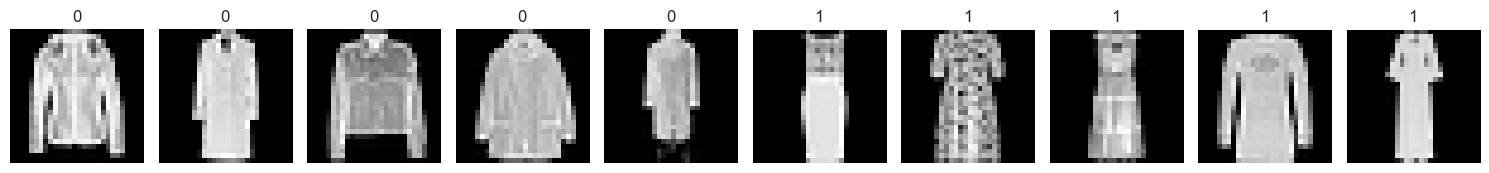

In [5]:
train_df = X_train.copy()
train_df['label'] = y_train.values
cls_h = train_df[train_df['label'] == 0].iloc[:5]
cls_s = train_df[train_df['label'] == 1].iloc[:5]
images = pd.concat([cls_h, cls_s], axis=0).reset_index(drop=True)
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    img_data = images.iloc[i, :-1].values.reshape(28, 28) 
    axes[i].imshow(img_data, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(int(images.iloc[i, -1]))  

plt.tight_layout()
plt.show()


### Škálování
* Data jsem škáloval pomocí MinMaxScaleru, protože SVM měl problém s předem nezpracovanými daty.

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## GaussianNB
### Vhodnost modelu
* Tento model není příliš vhodný pro data, která nejsou podmíněně nezávislá.
* I přesto však model funguje vcelku dobře a rychle.
* Vygenerováné obrázky obsahují hodně šumu, a proto takto vygenerované obrázky nevypadají moc dobře.
### Hyperparametry
* var_smoothing - numerická stabilita výpočtu
### První optimalizace

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

grid = {"var_smoothing": [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12], }
model_bnb = GaussianNB()
grid_bnb = GridSearchCV(model_bnb, grid, cv=5)
grid_bnb.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05,
                                           1e-06, 1e-07, 1e-08, 1e-09, 1e-10,
                                           1e-11, 1e-12]})

In [8]:
print(grid_bnb.best_params_)
print("Accuracy:", grid_bnb.best_score_)

{'var_smoothing': 0.0001}
Accuracy: 0.8791666666666667


### Druhá optimalizace


In [9]:
grid_gnb_2 = {"var_smoothing": [5e-4, 4e-4, 3e-4, 2e-4, 1e-4, 9e-5]}
gridsearch_gnb_2 = GridSearchCV(model_bnb, grid_gnb_2, cv=5)
gridsearch_gnb_2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [0.0005, 0.0004, 0.0003, 0.0002,
                                           0.0001, 9e-05]})

In [10]:
print(gridsearch_gnb_2.best_params_)
print("Accuracy:", gridsearch_gnb_2.best_score_)

{'var_smoothing': 0.0004}
Accuracy: 0.8799999999999999


### Výsledky
* Nejhroší výsledky v porovnání s ostatními modely
* Accuracy score 87.99 %. 

## Support vector machine
### Vhodnost modelu
* Model pro tato data funguje nejlépe, protože dobře pracuje s třídami, které jdou dobře oddělit.
* Tomuto modelu pomáhají vyškálovaná data, a proto jsem použil MinMaxScaler.
### Hyperparametry
* C - síla regularizace
* kernel - typ jádrové funkce
* gamma - dosah vlivu vzorků
### První optimalizace

In [11]:
from sklearn.svm import SVC

grid_svc = {"C": [0.1, 1, 3, 5, 7, 9, 11, 13], "kernel": ["linear", "poly", "rbf", "sigmoid"], "gamma": ["scale", "auto"],
            "random_state": [42]}
svc = SVC()
gridsearch_svc = GridSearchCV(svc, grid_svc, scoring="accuracy", cv=5)
gridsearch_svc.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 3, 5, 7, 9, 11, 13],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'random_state': [42]},
             scoring='accuracy')

In [12]:
print(gridsearch_svc.best_params_)
print("Accuracy:", gridsearch_svc.best_score_)

{'C': 5, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 42}
Accuracy: 0.9583333333333333


#### Druhá optimalizace

In [13]:
grid_svc_2 = {"C": [0.7, 0.8, 0.9, 1, 2, 3, 4, 5], "kernel": ["linear", "poly", "rbf", "sigmoid"],
              "gamma": ["scale", "auto"], "random_state": [42]}
svc = SVC()
gridsearch_svc_2 = GridSearchCV(svc, grid_svc_2, scoring="accuracy", cv=5)
gridsearch_svc_2.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.7, 0.8, 0.9, 1, 2, 3, 4, 5],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'random_state': [42]},
             scoring='accuracy')

In [14]:
print(gridsearch_svc_2.best_params_)
print("Accuracy:", gridsearch_svc_2.best_score_)

{'C': 4, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 42}
Accuracy: 0.9583333333333334


#### Třetí optimalizace

In [15]:
grid_svc_3 = {"C": [3.6,3.7,3.8, 3.9, 4, 4.1, 4.2, 4.3, 4.4, 4.5], "kernel": ["linear", "poly", "rbf", "sigmoid"],
              "gamma": ["scale", "auto"], "random_state": [42]}
svc = SVC()
gridsearch_svc_3 = GridSearchCV(svc, grid_svc_3, scoring="accuracy", cv=5)
gridsearch_svc_3.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [3.6, 3.7, 3.8, 3.9, 4, 4.1, 4.2, 4.3, 4.4, 4.5],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'random_state': [42]},
             scoring='accuracy')

In [16]:
print(gridsearch_svc_3.best_params_)
print("Accuracy:", gridsearch_svc_3.best_score_)

{'C': 3.8, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 42}
Accuracy: 0.9583333333333334


#### Finální optimalizace

In [17]:
grid_svc_4 = {"C": [3,73,3.74, 3.75, 3.76, 3.77, 3.78, 3.79,3.8, 3.81, 3.81, 3.82], "kernel": ["linear", "poly", "rbf", "sigmoid"],
              "gamma": ["scale", "auto"], "random_state": [42]}
svc = SVC()
gridsearch_svc_4 = GridSearchCV(svc, grid_svc_4, scoring="accuracy", cv=5)
gridsearch_svc_4.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [3, 73, 3.74, 3.75, 3.76, 3.77, 3.78, 3.79, 3.8,
                               3.81, 3.81, 3.82],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'random_state': [42]},
             scoring='accuracy')

In [18]:
print(gridsearch_svc_4.best_params_)
print("Accuracy:", gridsearch_svc_4.best_score_)

{'C': 3.74, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 42}
Accuracy: 0.9583333333333334


### Výsledky
* Model bez úpravy dimenzionality funguje nejlépe v porovnání s ostatními modely.
* Accuracy score dosáhl 96 %.

## Linear discriminant analysis
### Vhodnost modelu 
* Vhodný model pro tuto úlohu, protože hledá projekci dat do prostoru, kde jsou data nejlépe oddělitelná.
* Oproti SVM je mnohem rychlejší, ale dosahuje lehce horších výsledků.
* Dobře funguje při redukci dimenzionality.
### Hyperparametry
* solver - algoritmus výpočtu
* shrinkage - regularizace kovarianční matice
### První optimimalizace

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
param_grid_lda = {"solver": ["lsqr"],
                  "shrinkage": np.linspace(0, 1, 21),
                  }
grid_lda = GridSearchCV(lda, param_grid_lda, scoring="accuracy")
grid_lda.fit(X_train, y_train)

GridSearchCV(estimator=LinearDiscriminantAnalysis(),
             param_grid={'shrinkage': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                         'solver': ['lsqr']},
             scoring='accuracy')

In [20]:
print(grid_lda.best_params_)
print("Accuracy:", grid_lda.best_score_)


{'shrinkage': 0.4, 'solver': 'lsqr'}
Accuracy: 0.9475


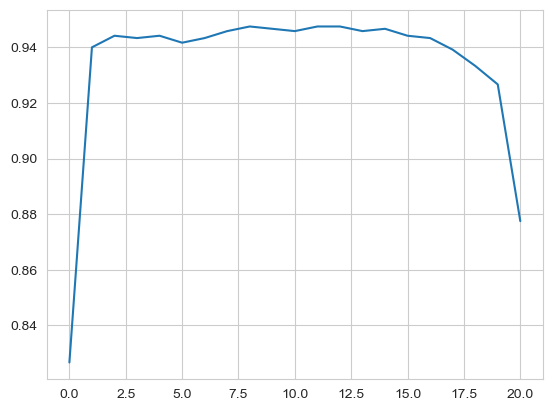

In [21]:
plt.plot(grid_lda.cv_results_['mean_test_score'])
plt.show()

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
param_grid_lda_eigen = {"solver": ["eigen"],
                        "shrinkage": np.linspace(0.05, 1, 20),
                        }
grid_lda_eigen = GridSearchCV(lda, param_grid_lda_eigen, scoring="accuracy")
grid_lda_eigen.fit(X_train, y_train)

GridSearchCV(estimator=LinearDiscriminantAnalysis(),
             param_grid={'shrinkage': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                         'solver': ['eigen']},
             scoring='accuracy')

In [23]:
print(grid_lda_eigen.best_params_)
print("Accuracy:", grid_lda_eigen.best_score_)



{'shrinkage': 0.39999999999999997, 'solver': 'eigen'}
Accuracy: 0.9475


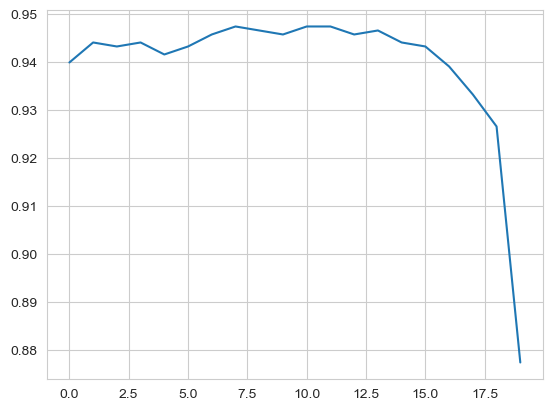

In [24]:
plt.plot(grid_lda_eigen.cv_results_['mean_test_score'])
plt.show()

### Výsledky
* Testoval jsem LDA s různými solvery (rozděleno, protože eigen + shrinkage=0 není možno)
* Oba dva solvery dávají stejné výsledky.
* LDA mělo o 1 % menší accuracy než SVC.
* Accuracy score dosáhl 94,75 %.

In [43]:
best_lda = grid_lda.best_estimator_
means = best_lda.means_
cov = best_lda.covariance_
classes = best_lda.classes_


# Generování obrázků
## Generování pomocí LDA
* LDA generuje lepší obrázky, než GNB
* Mikiny jsou lépe generovány než šaty

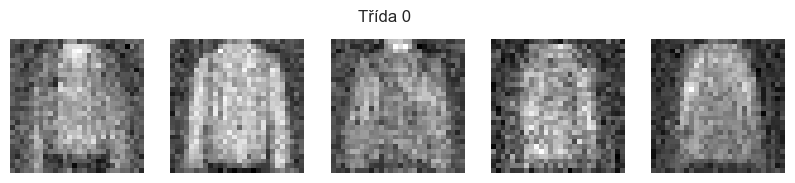

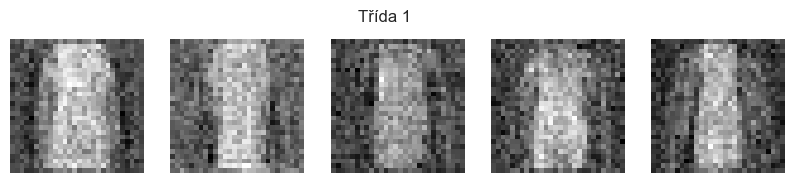

In [26]:
for i, cls in enumerate(classes):
    samples = np.random.multivariate_normal(mean=means[i], cov=cov, size=5)
    fig, axs = plt.subplots(1, 5, figsize=(10, 2))
    for j in range(5):
        axs[j].imshow(samples[j].reshape(28, 28), cmap='gray')
        axs[j].axis('off')
    plt.suptitle(f"Třída {cls}")
    plt.show()

## Generování pomocí GNB
* Obrázky obashují více šumu

(2, 784)

(2, 784)

(2,)

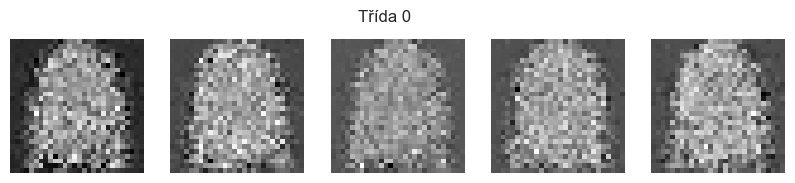

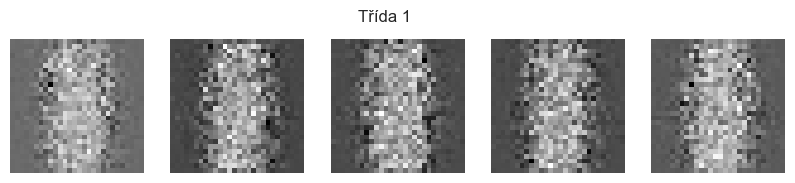

In [27]:
best_gnb = gridsearch_gnb_2.best_estimator_
means_gnb = best_gnb.theta_
var_gnb = best_gnb.var_
classes_gnb = best_gnb.classes_

display(means_gnb.shape, var_gnb.shape, classes_gnb.shape)
for i, cls in enumerate(classes_gnb):
    samples = np.random.normal(loc=means_gnb[i], scale=np.sqrt(var_gnb[i]), size=(5, means_gnb.shape[1]))
    fig, axs = plt.subplots(1, 5, figsize=(10, 2))
    for j in range(5):
        axs[j].imshow(samples[j].reshape(28, 28), cmap='gray')
        axs[j].axis('off')
    plt.suptitle(f"Třída {cls}")
    plt.show()

## PCA

In [ ]:
from sklearn.decomposition import PCA

val_acc_gnb = []
val_acc_svc = []
val_acc_lda = []
for i in range(2, 783, 1):
    print(i)
    pca = PCA(n_components=i, copy=True, random_state=42)
    X_new = pca.fit_transform(X_train)

    print(i, ".", 1, sep="")
    grid_gnb_pca = {"var_smoothing": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]}
    model_gnb_pca = GaussianNB()
    gridsearch_gnb_pca = GridSearchCV(model_gnb_pca, grid_gnb_pca, cv=5)
    gridsearch_gnb_pca.fit(X_new, y_train)
    val_acc_gnb.append(gridsearch_gnb_pca.best_score_)

    print(i, ".", 2, sep="")
    grid_svc_pca = {"C": [3 ,3.5, 3.75, 4, 5], "kernel": [ "rbf"], "gamma": ["scale"], "random_state": [42]}
    svc_pca = SVC()
    gridsearch_svc_pca = GridSearchCV(svc_pca, grid_svc_pca, scoring="accuracy", cv=3)
    gridsearch_svc_pca.fit(X_new, y_train)
    val_acc_svc.append(gridsearch_svc_pca.best_score_)

    print(i, ".", 3, sep="")
    lda_pca = LinearDiscriminantAnalysis()
    grid_lda_pca = {"solver": ["eigen"],
                    "shrinkage": np.linspace(0.1, 1, 5)
                    }
    gridsearch_lda_pca = GridSearchCV(lda_pca, grid_lda_pca, scoring="accuracy")
    gridsearch_lda_pca.fit(X_new, y_train)
    val_acc_lda.append(gridsearch_lda_pca.best_score_)



### Vyhodnocení PCA
* Nejlepších výsledků dosahuje SVC, druhý je LDA a nejhorších výsledků dosahuje GNB.
* Nejlepší výsledky pozorujeme v oblasti od 5 komponent do 200 komponent. 
* Při přiliš nízkém počtu komponent data ztrácí variabilitu a příliš vysoké hodnoty se ustálí a nepozurjeme žádné zjevné zlepšení.
* Jedinou vyjímkou je GNB, kde se model zhoršuje.
* U GNB pozorujeme výrazný vrchol v přesnosti již na nízkých dimenzích. Poté následuje mírný pokles a opět růst, který však nedosahuje výsledků prvotního vrcholu. 
* Model SVC dosáhl vrcholu přesnosti kolem 50. dimenze a od té doby pozorujeme mírný pokles. Tento model má nejlepší přesnost ve všech dimenzích PCA.
* Nakonec u LDA pozorujeme trend růstu přesnosti s růstem dimenze.

In [29]:
print("Max GNB acc:", max(val_acc_gnb))
print("Dimension", np.argmax(val_acc_gnb) + 2)
print("Max SVC acc:", max(val_acc_svc))
print("Dimension", np.argmax(val_acc_svc) + 2)
print("Max LDA acc:", max(val_acc_lda))
print("Dimension", np.argmax(val_acc_lda) + 2)

Max GNB acc: 0.9099999999999999
Dimension 13
Max SVC acc: 0.96
Dimension 57
Max LDA acc: 0.9491666666666667
Dimension 168


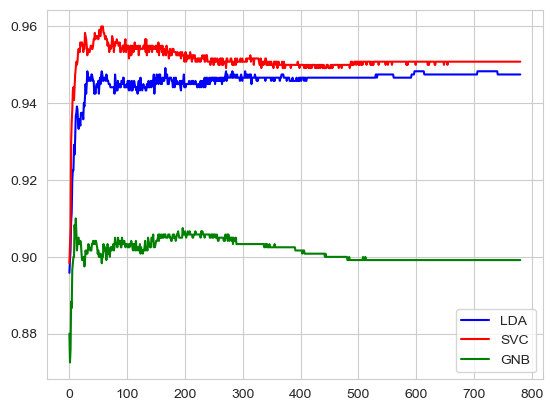

In [44]:
import matplotlib.pyplot as plt

plt.plot(val_acc_lda, color='blue', label='LDA')
plt.plot(val_acc_svc, color='red', label='SVC')
plt.plot(val_acc_gnb, color='green', label='GNB')
plt.legend()
plt.show()

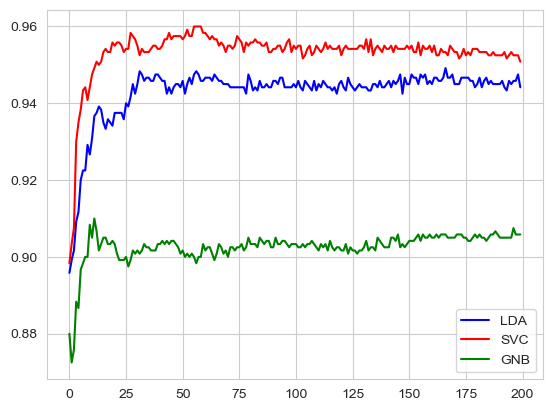

In [45]:
import matplotlib.pyplot as plt

plt.plot(val_acc_lda[:200], color='blue', label='LDA')
plt.plot(val_acc_svc[:200], color='red', label='SVC')
plt.plot(val_acc_gnb[:200], color='green', label='GNB')
plt.legend()
plt.show()

## LLE

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

grid_lle = ParameterGrid({"n_components": [x for x in range(1, round(X_train.shape[1] / 4), 10)],
                          "n_neighbors": [x for x in range(5, 50, 5)], })
val_lle_gnb = []
val_lle_svc = []
val_lle_lda = []
ind = 0
for params in grid_lle:
    ind += 1
    print(ind, "/", len(grid_lle))
    lle = LocallyLinearEmbedding(**params)
    X_new_lle = lle.fit_transform(X_train)

    grid_gnb_lle = {"var_smoothing": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6], }
    model_gnb_lle = GaussianNB()
    gridsearch_gnb_lle = GridSearchCV(model_gnb_lle, grid_gnb_lle, cv=5)
    gridsearch_gnb_lle.fit(X_new_lle, y_train)
    val_lle_gnb.append(gridsearch_gnb_lle.best_score_)

    grid_svc_lle = {"C": [3 ,3.5, 3.75, 4, 5], "kernel": [ "rbf"], "gamma": ["scale"], "random_state": [42]}
    svc_lle = SVC()
    gridsearch_svc_lle = GridSearchCV(svc_lle, grid_svc_lle, scoring="accuracy", cv=5)
    gridsearch_svc_lle.fit(X_new_lle, y_train)
    val_lle_svc.append(gridsearch_svc_lle.best_score_)

    lda_lle = LinearDiscriminantAnalysis()
    grid_lda_lle = {"solver": ["eigen"],
                    "shrinkage": np.linspace(0.1, 1, 5)
                    }
    gridsearch_lda_lle = GridSearchCV(lda_lle, grid_lda_lle, scoring="accuracy")
    gridsearch_lda_lle.fit(X_new_lle, y_train)
    val_lle_lda.append(gridsearch_lda_lle.best_score_)


### Vyhodnocení LLE
* Při testování různých hyperparametrů LLE dosáhl opět nejlepších výsledků SVC.
* Velice blízko hranici 96 % accuracy se pohybovalo i LDA. 
* GNB v kombinaci s LLE začal dosahovat dobrých výsledků, ale oproti ostatním modelům je stále nejhorší.
* Modely SVC a LDA byly mnohem více vyrovnané než v případě PCA. 

In [33]:
print("Max GNB acc:", max(val_lle_gnb))

print("Max SVC acc:", max(val_lle_svc))

print("Max LDA acc:", max(val_lle_lda))


Max GNB acc: 0.9241666666666667
Max SVC acc: 0.9558333333333333
Max LDA acc: 0.9575000000000001


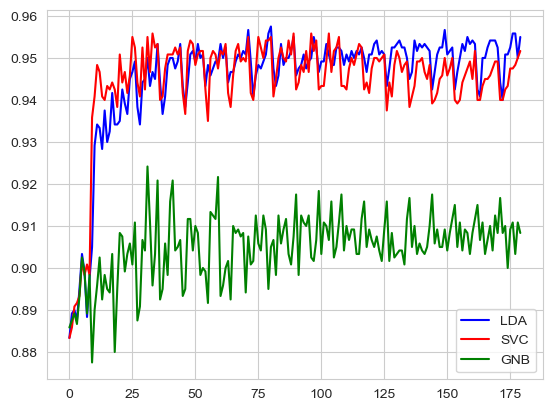

In [47]:
import matplotlib.pyplot as plt

plt.plot(val_lle_lda, color='blue', label='LDA')
plt.plot(val_lle_svc, color='red', label='SVC')
plt.plot(val_lle_gnb, color='green', label='GNB')
plt.legend()
plt.show()

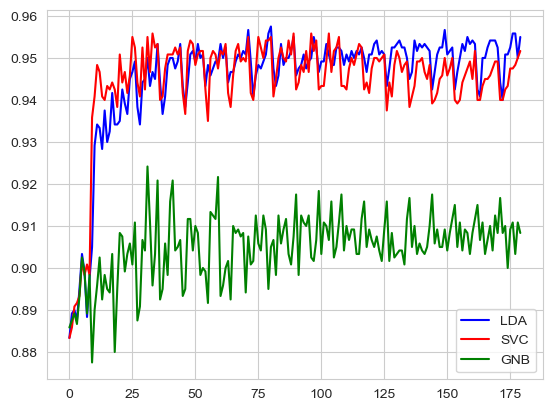

In [48]:
import matplotlib.pyplot as plt

plt.plot(val_lle_lda[:200], color='blue', label='LDA')
plt.plot(val_lle_svc[:200], color='red', label='SVC')
plt.plot(val_lle_gnb[:200], color='green', label='GNB')
plt.legend()
plt.show()

# Vyhodnocení nejlepšího modelu na testovací množině 

In [36]:
pca_final = PCA(n_components=57, copy=True, random_state=42)
X_final = pca_final.fit_transform(X_train)

grid_svc_pca_final = {"C": [3 ,3.5, 3.75, 4, 5], "kernel": [ "rbf"], "gamma": ["scale"], "random_state": [42]}
svc_pca_final = SVC()
gridsearch_svc_pca_final = GridSearchCV(svc_pca_final, grid_svc_pca_final, scoring="accuracy", cv=3)
gridsearch_svc_pca_final.fit(X_final, y_train)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [3, 3.5, 3.75, 4, 5], 'gamma': ['scale'],
                         'kernel': ['rbf'], 'random_state': [42]},
             scoring='accuracy')

In [37]:
print(gridsearch_svc_pca_final.best_score_)
print("Accuracy:", gridsearch_svc_pca_final.best_params_)

0.96
Accuracy: {'C': 3, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 42}


In [38]:
X_final_test = pca_final.transform(X_test)
final_model_svc = gridsearch_svc_pca_final.best_estimator_
y_pred_final = final_model_svc.predict(X_final_test)


### Výsledky 
* Model jsem vybral pomocí nejlepší CV accuracy na PCA, LLE a původním datasetu.
* Accuracy score na trénovací množině byla srovnatelná s výsledky CV, což naznačuje, že se model nepřetrénoval.
* Na neznámých datech můžeme tudíž očekávat podobné výsledky.
* Model dále dosáhl AUC skóre 0.95, což znamená, že model dobře rolzišuje mezi oběma třídami. 

In [39]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score

print(f"Accuracy score:  {(accuracy_score(y_test, y_pred_final) * 100):.2f} %")
print(f"F1 score:  {(f1_score(y_test, y_pred_final)):.4f}")


Accuracy score:  95.00 %
F1 score:  0.9416


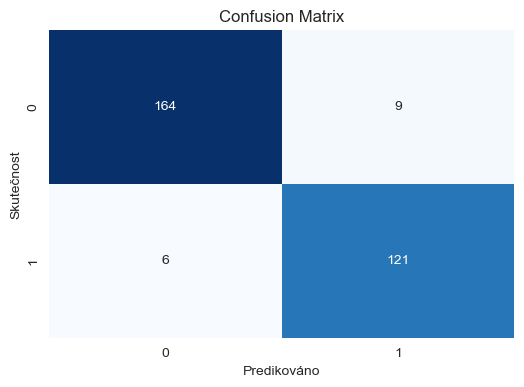

In [40]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predikováno')
plt.ylabel('Skutečnost')
plt.title('Confusion Matrix')
plt.show()



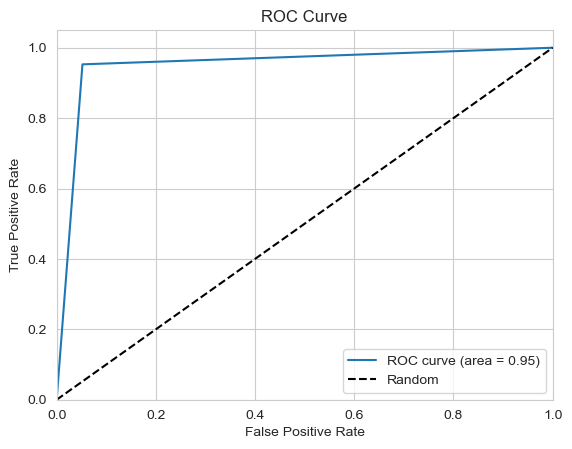

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_final)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Evaluační množina

In [42]:
df_evaluation = pd.read_csv('evaluate.csv')
id_eval = df_evaluation['ID']
scaled_df = scaler.transform(df_evaluation.drop(['ID'], axis=1))
pca_eval = pca_final.transform(scaled_df)

y_pred_eval = final_model_svc.predict(pca_eval)
res = pd.concat([id_eval, pd.DataFrame(y_pred_eval)], axis=1)
res.rename(columns={0: 'label'}, inplace=True)
res.to_csv("results.csv", index=False)
display(res)

,ID,label
0,0,1
1,1,1
2,2,0
3,3,0
4,4,0
...,...,...
1495,1495,1
1496,1496,0
1497,1497,0
1498,1498,0
